# Cyclists Dataset Understanding

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from sklearn.impute import KNNImputer
import random
import math
import seaborn as sb
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('../src'))

from utils import *

In [3]:
complete_data = pd.read_csv('../data/complete_dataset.csv')
races = pd.read_csv("../data/races.csv")

In [4]:
dataset = pd.read_csv("../data/cyclists.csv")
dataset.head()

,_url,name,birth_year,weight,height,nationality
0,bruno-surra,Bruno Surra,1964.0,NaN,NaN,Italy
1,gerard-rue,Gérard Rué,1965.0,74.0,182.0,France
2,jan-maas,Jan Maas,1996.0,69.0,189.0,Netherlands
3,nathan-van-hooydonck,Nathan Van Hooydonck,1995.0,78.0,192.0,Belgium
4,jose-felix-parra,José Félix Parra,1997.0,55.0,171.0,Spain


## Syntactic and Semantic accuracies analysis

Nel notebook "cyclists_possible_errors.ipynb" abbiamo verificato informazioni generiche sui nostri dati. In questa sezione invece studiamo più nel dettaglio il tipo degli attributi, verificando come questi tipi possano essere cambiati qualora non sinao idonei al dominio degli attributi, verificando inoltre che i valori non NaN presenti nel dataset risultino all'interno dei rispettivi domini

In [5]:
dataset.info()
# birth year, heigth -> float to int

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134 entries, 0 to 6133
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _url         6134 non-null   object 
 1   name         6134 non-null   object 
 2   birth_year   6121 non-null   float64
 3   weight       3078 non-null   float64
 4   height       3143 non-null   float64
 5   nationality  6133 non-null   object 
dtypes: float64(3), object(3)
memory usage: 287.7+ KB


In [6]:
# birth_year è logicamente un intero mentre altezza e peso possono ragionevolmente essere considerati float
dataset['birth_year'] = dataset[dataset['birth_year'].notnull()]['birth_year'].astype(int)

In [7]:
dataset.describe()

,birth_year,weight,height
count,6121.000000,3078.000000,3143.000000
mean,1974.071884,68.658739,179.815145
std,15.535834,6.348183,6.443447
min,1933.000000,48.000000,154.000000
25%,1962.000000,64.000000,175.000000
50%,1974.000000,69.000000,180.000000
75%,1987.000000,73.000000,184.000000
max,2004.000000,94.000000,204.000000


In [8]:
print(f'Number of duplicates: {len(dataset)-len(dataset.drop_duplicates())}')

Number of duplicates: 0


### Confronto tra ciclisti presenti nel dataset cyclists.csv e races.csv

Abbiamo individuato 39 ciclisti registrati nel dataset "cyclists.csv" e assenti nel dataset "races.csv". Abbiamo inoltre confermato che tutti i ciclisti registrati nel dataset "races.csv" sono presenti nel dataset "cyclists.csv" e che di conseguenza i dati aggiuntivi presenti in quest'ultimo sono soltanto un "extra" rispetto a dati altrimenti coerenti tra i due dataset 

In [9]:
len(dataset['_url'].unique()), len(races['cyclist'].unique())

(6134, 6095)

In [10]:
dataset[~dataset['_url'].isin(races['cyclist'])]

,_url,name,birth_year,weight,height,nationality
578,jean-michel-thilloy,Jean-Michel Thilloy,1966.0,NaN,NaN,France
902,gert-van-brabant,Gert Van Brabant,1968.0,NaN,NaN,Belgium
1046,roman-bronis,Roman Broniš,1976.0,74.0,187.0,Slovakia
1176,oleg-grishkine,Oleg Grishkine,1975.0,NaN,NaN,Russia
1330,eddy-torrekens,Eddy Torrekens,1970.0,NaN,NaN,Belgium
1449,philipp-ludescher,Philipp Ludescher,1987.0,72.0,187.0,Austria
1486,nicolas-liboreau,Nicolas Liboreau,1977.0,NaN,NaN,France
1538,gino-primo,Gino Primo,1966.0,NaN,NaN,Belgium
1566,luca-braidot,Luca Braidot,1991.0,69.0,179.0,Italy
1718,tanner-putt,Tanner Putt,1992.0,75.0,178.0,United States


In [11]:
races[~races['cyclist'].isin(dataset['_url'])]

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta


## Data-Balance Analysis 

In questa sezione studiamo il bilanciamento e la rappresentazione dei vari attributi del dataset

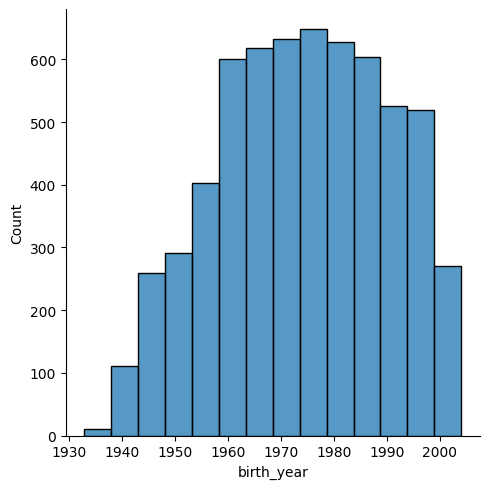

In [12]:
n_bins = math.ceil(math.log2(len(dataset)) + 1)

sb.displot(dataset, 
                x="birth_year", 
                kind="hist",
                row_order="desc",
                bins=n_bins) #TODO: cambia nome dell'asse x

Anni di nascista dell'ultimo secolo, valori nei range che ci possiamo aspettare.
I ciclisti con maggiore rappresentanza sono quelli nati prima del 2000 a partire dagli anni 60.

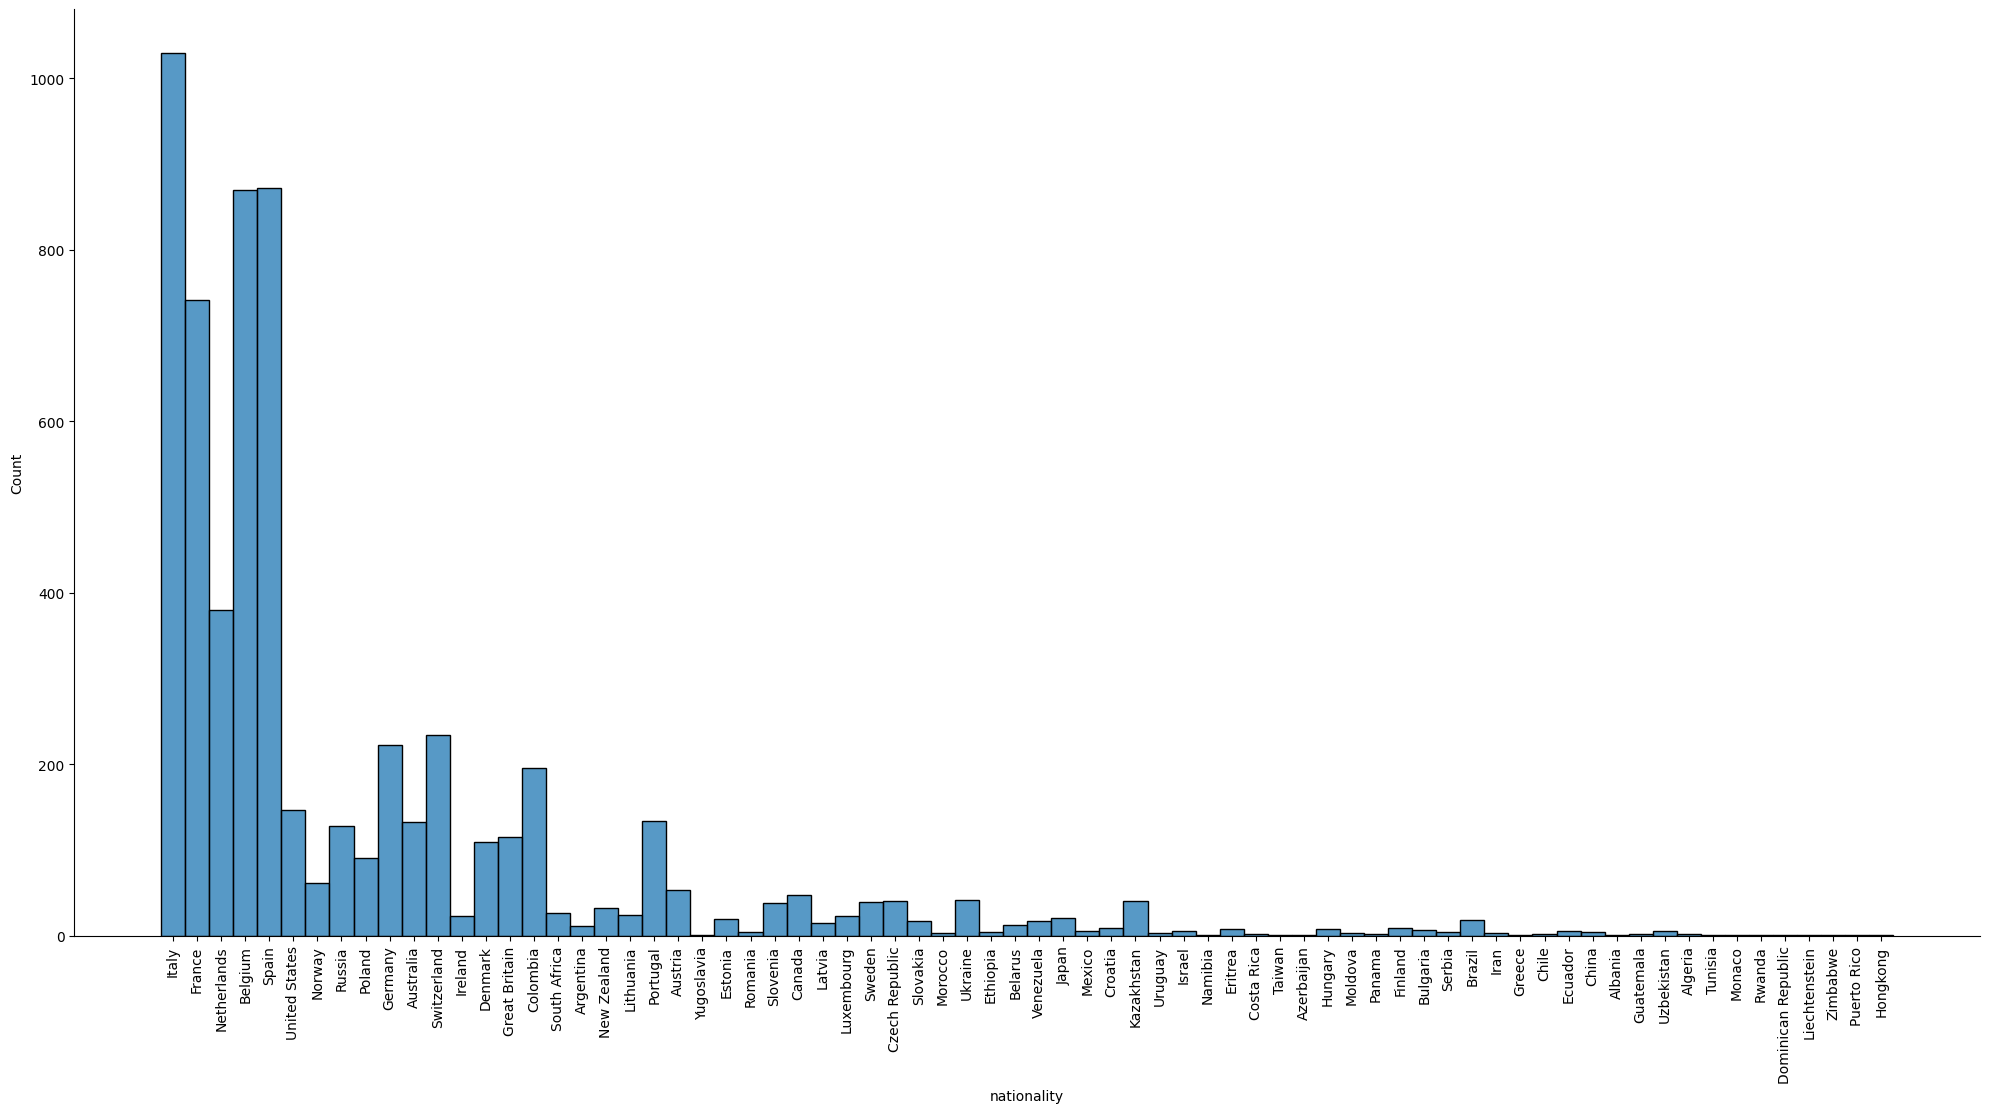

In [13]:
sb.displot(dataset, 
                x="nationality", 
                kind="hist",
                row_order="desc",
                bins=len(dataset['nationality'].unique()),
                height=10,
                aspect=2)
plt.xticks(rotation=90);

Il nostro dataset presenta una maggioranza di dati per nazionalità europee. 

Motivazioni plausibili:
1. Il ciclismo è uno sport storicamente più rilevante in europa;
2. Le gare più importanti si tengono in europa:

    * Atleti più appasionati allo sport sono europei;
    * Gli atleti di nazioni distanti da quelle europee sono meno partecipi alle gare europee;
3. Il nostro dataset presenta dei bias sulle nazionalità dei ciclisti selezionati o sulle gare a cui questi hanno partecipato.

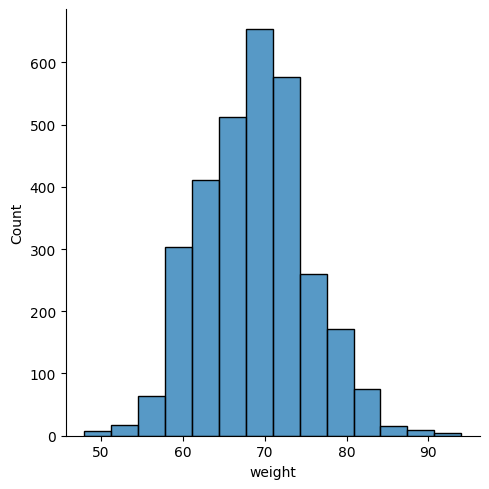

In [14]:
sb.displot(dataset, 
                x="weight", 
                kind="hist",
                row_order="desc",
                bins=n_bins)

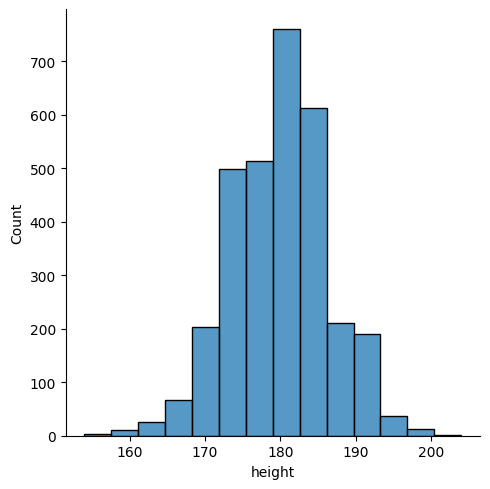

In [15]:
sb.displot(dataset, 
                x="height", 
                kind="hist",
                row_order="desc",
                bins=n_bins)

Secondo i dati da noi raccolti da fonti (citare) l'altezza media dei ciclisti dovrebbe essere tra i 175 e i 185 cm con un peso variabile tra i 60 e 70 Kg. I nostri grafici confermano questi dati con le classi maggioritarie per gli attributi localizzate in corrispodnenza di queste medie. Possiamo supporre che la sottorappresentazione dei valori superiori e inferiori non sia dovuta a bias del nostro dataset quanto alla naturale distribuzione statistica del ciclismo

Guardando i grafici precedenti è possibile ricercare la presenza di valori di default che nascondono mancanze nel dataset. Abbiamo rilevato che la distribuzione dei valori è simile a quella che ci potremmo attendere, se ci fosse stato un valore di default la sua frequenza sarebbe stata fuori scala. Da questo momento in poi considereremo questi attributi come privi di valori di default.

In [47]:
cyclists = complete_data.groupby(by=['cyclist_url'])['race_url'].nunique().reset_index().sort_values(by='race_url')

In [51]:
cyclists['race_url'].describe()

count    6095.000000
mean       96.757834
std       140.786564
min         1.000000
25%         5.000000
50%        30.000000
75%       133.000000
max       959.000000
Name: race_url, dtype: float64

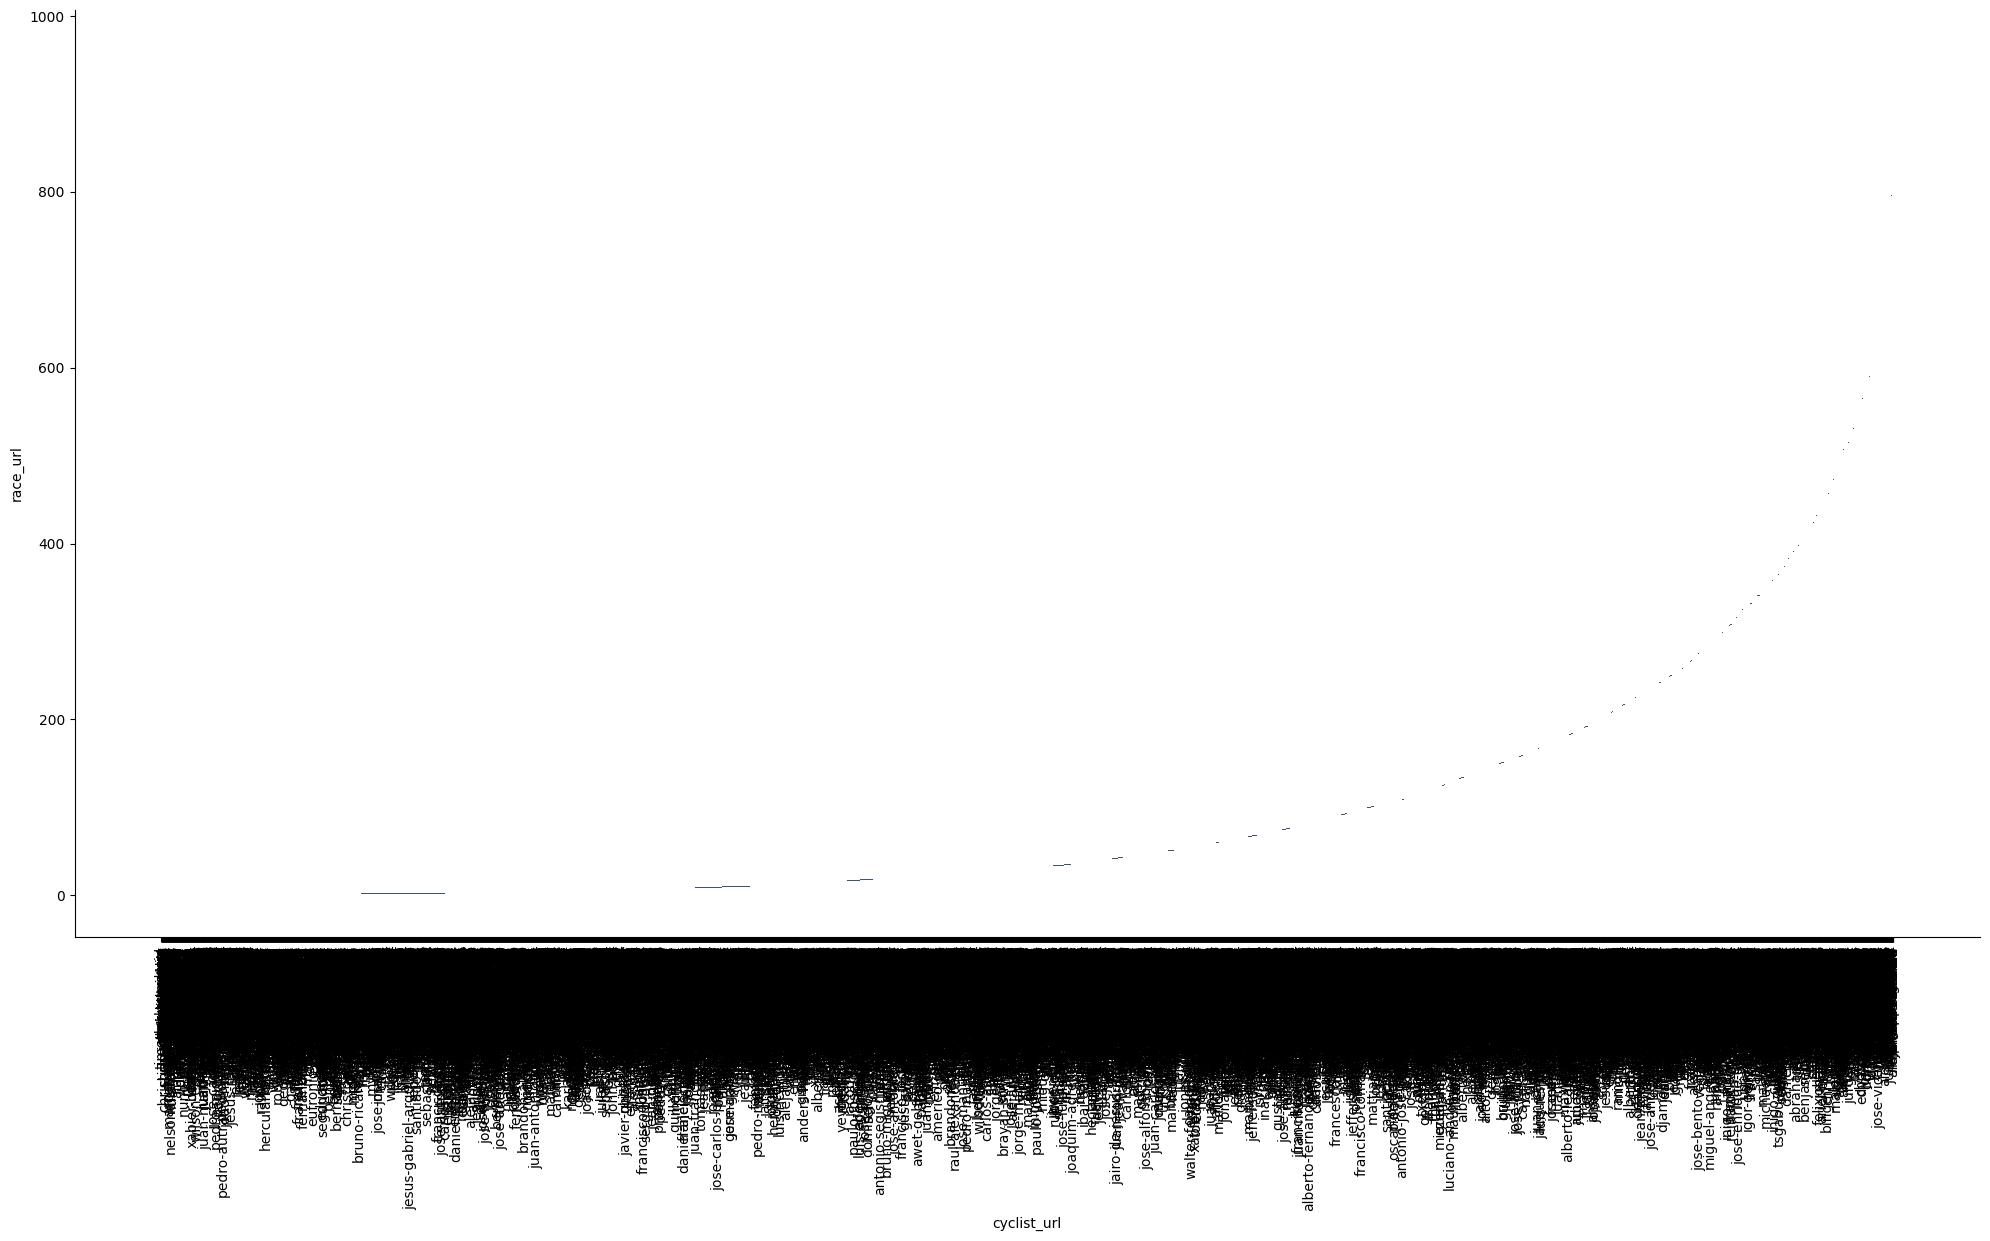

In [ ]:
sb.displot(cyclists, #TODO: sistema sta merda
                x="cyclist_url", 
                y='race_url',
                kind="hist",
                row_order="desc",
                bins=cyclists['cyclist_url'].nunique(),
                height=10,
                aspect=2)

plt.xticks(rotation=90);

## Completeness Analysis
### Analisi dei NaN values

In [17]:
dataset.isnull().sum()

_url              0
name              0
birth_year       13
weight         3056
height         2991
nationality       1
dtype: int64

In [18]:
percent_missing = dataset.isnull().sum() * 100 / len(dataset) # compute the percentage of missing values
missing_value_df = pd.DataFrame({'column_name': dataset.columns,
                                 'percent_missing': percent_missing})

missing_value_df['percent_missing']

_url            0.000000
name            0.000000
birth_year      0.211933
weight         49.820672
height         48.761004
nationality     0.016303
Name: percent_missing, dtype: float64

## Imputation

### Tentativo di imputazione manuale delle date di nascita mancanti sfruttando i dati del dataset 'races.csv'

I ciclisti nel dataset 'cyclist.csv' che presentano età NaN, non presentano un riscontro non-NaN dell'attributo "birth_year" nel dataset 'races.csv'. A causa di ciò non possiamo sfruttare informazioni del secondo dataset per completare il primo

In [19]:
missing_birthyear = dataset[dataset['birth_year'].isnull()]['_url'].to_list()
tmp_df = races[races['cyclist'].isin(missing_birthyear)]
tmp_df[tmp_df['cyclist_age'].notnull()]

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta


Abbiamo cercato di recuperare più dati possibile manualmente attraverso ricerce online supportate da confronti diretti con altri dati presenti nel dataset 'races.csv'

Una volta identificato un ciclista con alta probabilità abbiamo fatto una imputazione manuale del valore ottenuto nella feature 'birth_year' corrispondente

In [20]:
dataset.loc[dataset['_url'] == 'scott-davies', 'birth_year'] = 1995
dataset.loc[dataset['_url'] == 'vladimir-malakov', 'birth_year'] = 1958
dataset.loc[dataset['_url'] == 'antonio-zanini', 'birth_year'] = 1965
dataset.loc[dataset['_url'] == 'nevens-guy', 'birth_year'] = 1962
dataset.loc[dataset['_url'] == 'sergei-jermachenko', 'birth_year'] = 1956 

Ragionamento simile fatto anche per la nazionalità. L'unica mancante apparteneva al ciclista Scott Davies che era già stato correttamente identificato nella fase precedente, grazie a cui abbiamo rivenuto anche questa informazione

In [21]:
dataset.loc[dataset['_url'] == 'scott-davies', 'nationality'] = 'Great Britain'

In [22]:
dataset['birth_year'] = dataset['birth_year'].fillna(dataset['birth_year'].mode()[0]) # substitue 8 remaining elements with mode

In [23]:
dataset.isnull().sum() # check if missing values are filled correctly

_url              0
name              0
birth_year        0
weight         3056
height         2991
nationality       0
dtype: int64

### Imputation per altezza e peso

La nostra ipotesi di partenza è che altezza peso e nazionalità siano correlati. Desidereremmo sfruttare questa informazione per eseguire una imputazione di vicinanza nei record incompleti. 

Per poter procedere con questa strategia è essenziale stabilire le reali correlazioni tra questi attributi (confermando o smentendo quelle attese o scoprendone di nuove)

Now we consider the `weight` and `height` columns together, and we check the combinations of null values

In [24]:
# Filter rows where 'weight' is null and 'height' is not null
missing_weight_with_height = dataset[dataset['weight'].isnull() & dataset['height'].notnull()]

print("Cyclists where we have only the height:", len(missing_weight_with_height))
for index, row in missing_weight_with_height.iterrows():
    print(row['_url'], row['height'])


Cyclists where we have only the height: 72
idar-andersen 182.0
thomas-bonnet 175.0
syver-waersted 193.0
loe-van-belle 184.0
negasi-abreha 186.0
davide-baldaccini 176.0
pier-andre-cote 181.0
valere-thiebaud 184.0
louis-bendixen 190.0
robin-carpenter 178.0
vicente-belda 154.0
emanuel-duarte 182.0
embret-svestad-bardseng 185.0
joaquim-adrego-pereira-andrade 175.0
jacob-eriksson 182.0
xabier-isasa-larranaga 185.0
ivan-quaranta 174.0
luis-ocana 178.0
alfons-de-bal 155.0
adam-de-vos 187.0
yanto-barker 182.0
umberto-poli 167.0
dario-lillo 185.0
miguel-heidemann 186.0
torstein-traeen 181.0
bogdan-bondariew 196.0
anders-halland-johannessen 176.0
christian-raymond 178.0
max-poole 185.0
andrzej-mierzejewski 173.0
venceslau-fernandes 181.0
sandy-dujardin 178.0
oliver-rees 184.0
charly-mottet 164.0
johannes-staune-mittet 182.0
rob-britton 188.0
jonas-iversby-hvideberg 185.0
sergey-kolesnikov 179.0
sebastian-kolze-changizi 181.0
vadim-kravchenko 178.0
libardo-nino-corredor 182.0
joan-bou 182.0
wladi

In [25]:
# Filter rows where 'weight' is not null and 'height' is null
missing_height_with_weight = dataset[dataset['weight'].notnull() & dataset['height'].isnull()]

print("Cyclists where we have only the weight:", len(missing_height_with_weight))
for index, row in missing_height_with_weight.iterrows():
    print(row['_url'], row['weight'])

Cyclists where we have only the weight: 7
mario-de-sarraga 69.0
frank-hoste 76.0
davide-orrico 70.0
nicolas-dalla-valle 73.0
nils-brun 64.0
yannis-voisard 56.0
jean-nuttli 70.0


In [26]:
# Filter rows where both 'weight' and 'height' are null
missing_weight_missing_height = dataset[dataset['weight'].isnull() & dataset['height'].isnull()]

print("Cyclists where we dont' have both weight and height:", len(missing_weight_missing_height))
for index, row in missing_weight_missing_height.iterrows():
    print(row['_url'])

Cyclists where we dont' have both weight and height: 2984
bruno-surra
willy-moonen
scott-davies
stian-remme
evgueny-anachkine
maurizio-biondo
patrice-thevenard
luc-suykerbuyk
alain-gallopin
urs-graf
jean-claude-theilliere
paul-kimmage
alejandro-paleo
samuel-blanco
sean-sullivan
gaetano-baronchelli
julien-mazet
roberto-giucolsi
leonardo-guidi
aitor-alonso
noel-vanclooster
jesus-rodriguez-rodriguez
noan-lelarge
eric-van-lancker
luca-maggioni
christian-muselet
marc-siemons
theo-smit
luigi-sestili
iban-herrero-atienzar
jules-bruessing
theo-eltink
willy-vigouroux
venancio-teran
valentin-dorronsoro
eddy-verstraeten
paulo-jose-dos-santos-ferreira
wim-omloop
sascha-henrix
manuele-tarozzi
roy-knickman
luigi-della-bianca
jannes-slendebroek
primoz-cerin
francisco-leon
anselmo-fuerte-abelenda
nic-hamilton
alain-van-den-bossche
hubert-arbes
peter-van-de-knoop
louis-de-koning
harm-ottenbros
stephan-joho
miroslav-uryga
luis-ricardo-mesa-saavedra
marco-villa
jacques-jolidon
dirk-wayenberg
jose-salvado

In [27]:
dataset[dataset['height'].isnull() & dataset['weight'].isnull()]

,_url,name,birth_year,weight,height,nationality
0,bruno-surra,Bruno Surra,1964.0,NaN,NaN,Italy
6,willy-moonen,Willy Moonen,1947.0,NaN,NaN,Belgium
9,scott-davies,Scott Davies,1995.0,NaN,NaN,Great Britain
10,stian-remme,Stian Remme,1982.0,NaN,NaN,Norway
13,evgueny-anachkine,Evgueny Anachkine,1970.0,NaN,NaN,Russia
...,...,...,...,...,...,...
6123,francisque-teyssier,Francisque Teyssier,1969.0,NaN,NaN,France
6127,hendrik-van-dyck,Hendrik Van Dyck,1974.0,NaN,NaN,Belgium
6128,francisco-jose-pacheco,Francisco José Pacheco,1982.0,NaN,NaN,Spain
6129,juan-jose-martinez-diaz,Juan José Martínez,1966.0,NaN,NaN,Spain


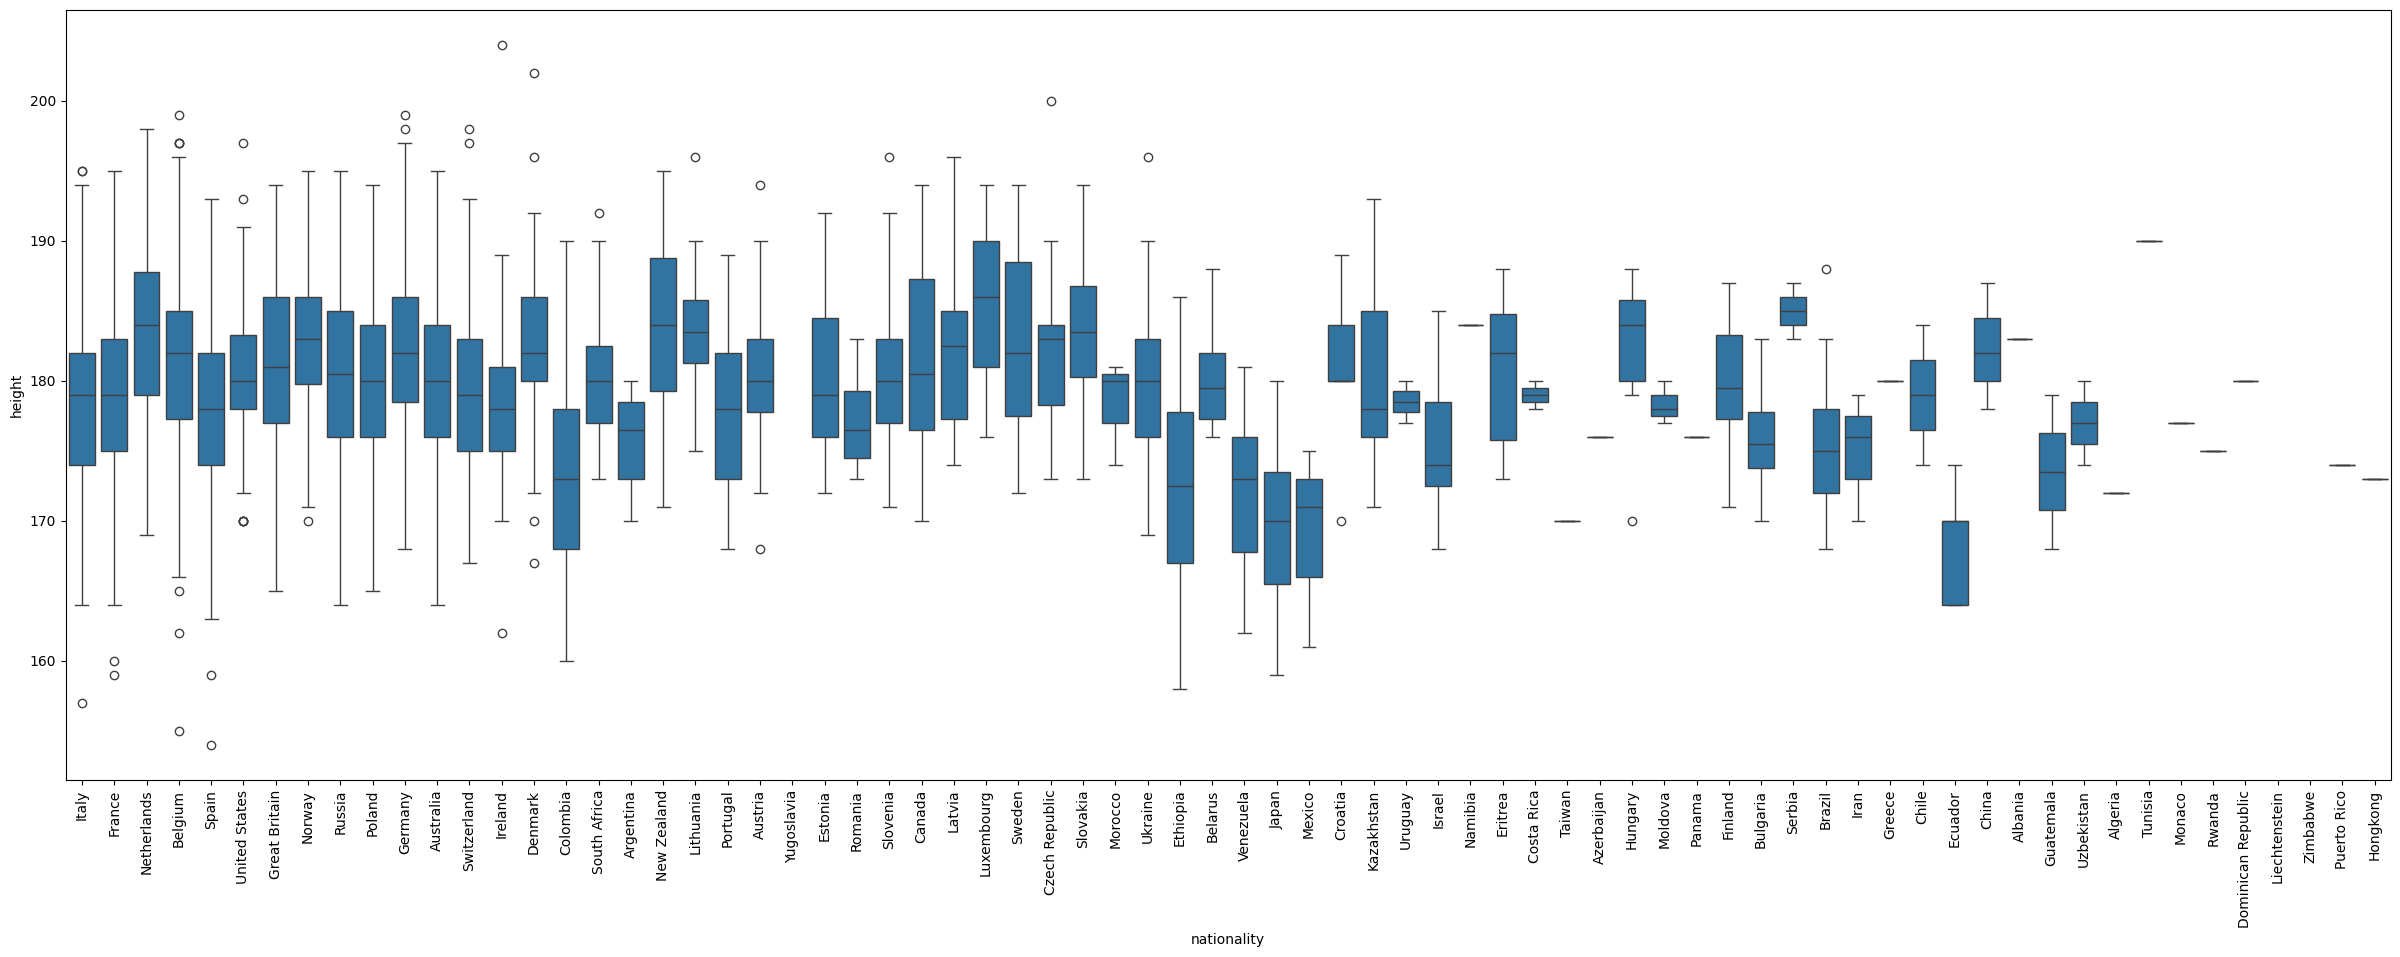

In [28]:
plt.figure(figsize=(30, 10))
sb.boxplot(x='nationality', y='height', data=dataset)
plt.xticks(rotation=90);
plt.show()

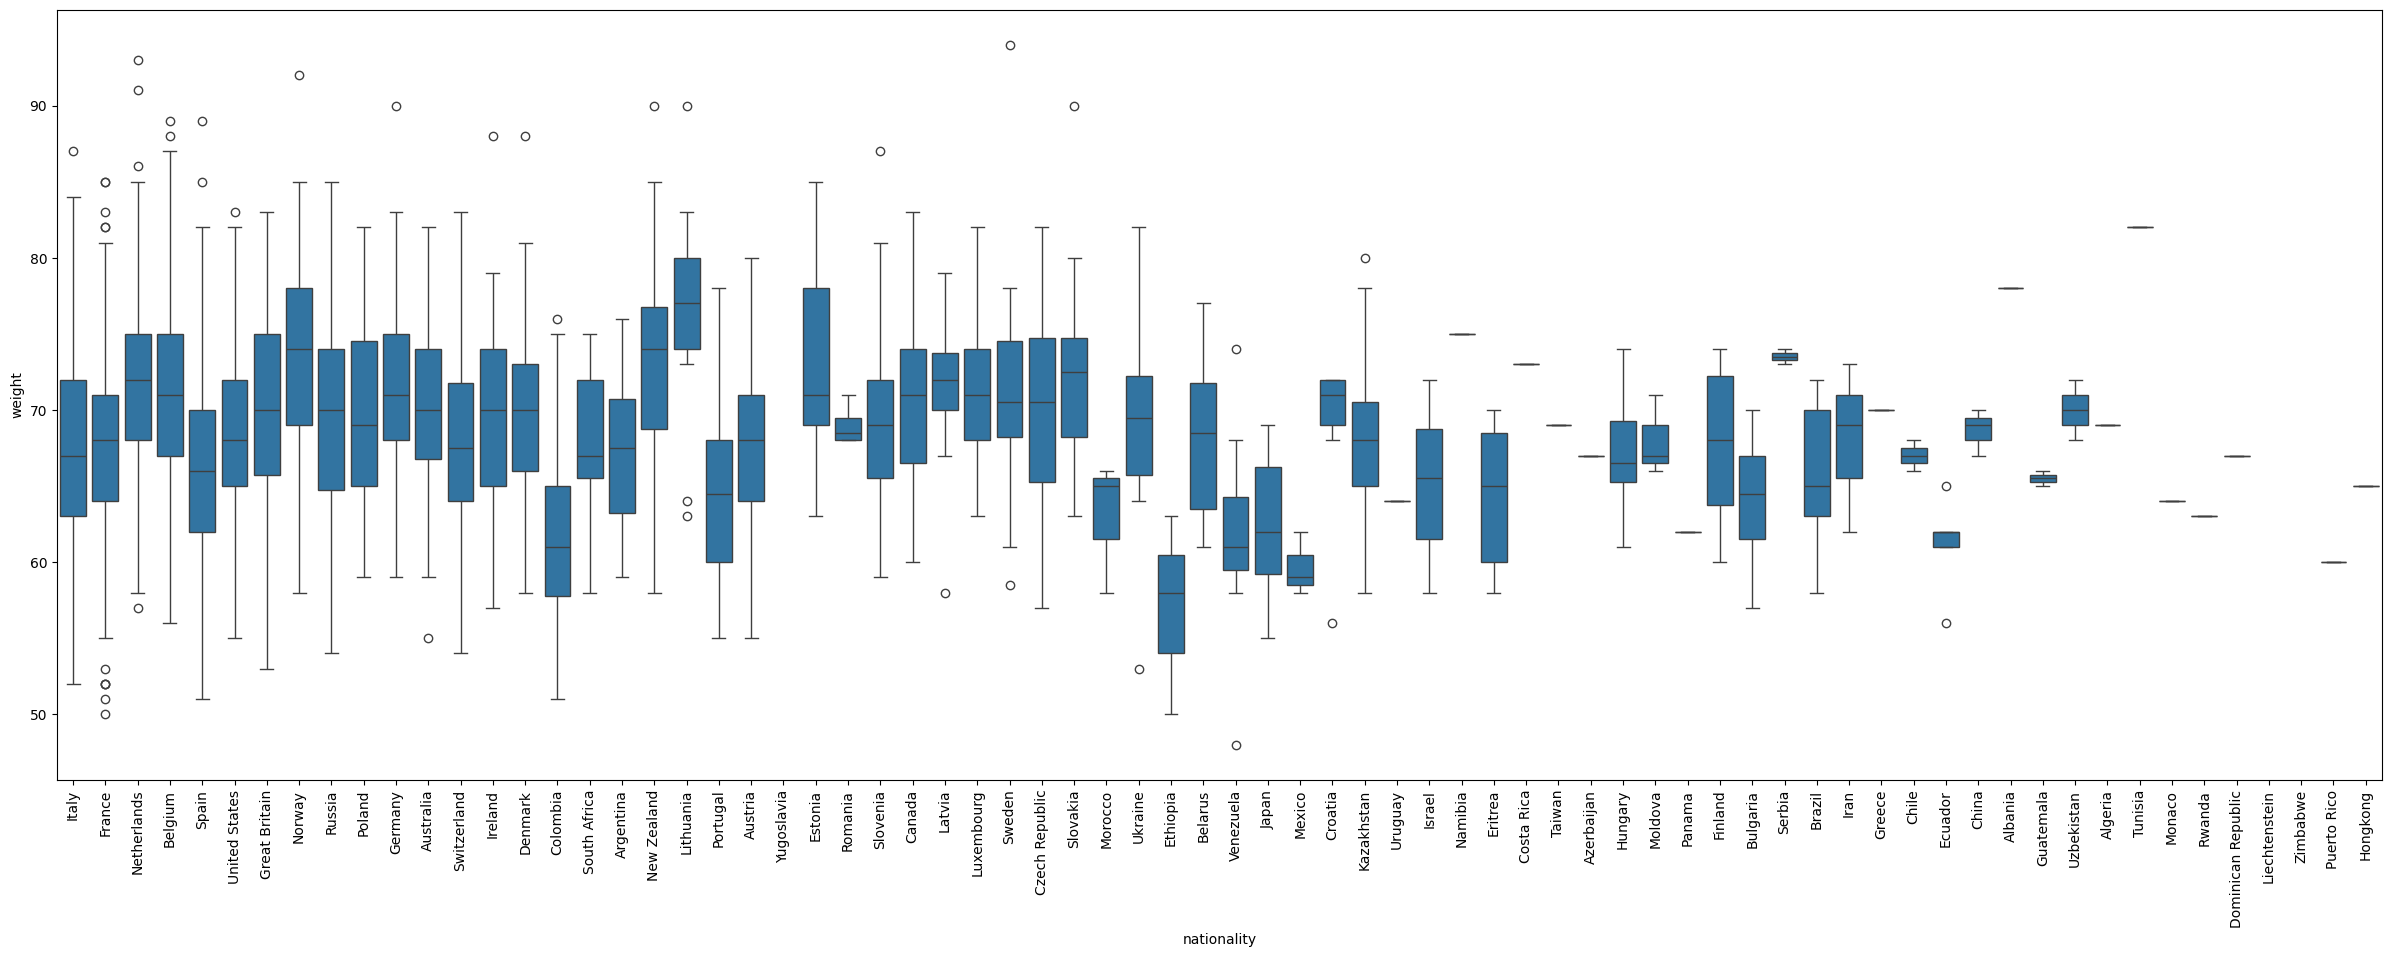

In [29]:
plt.figure(figsize=(30, 10))
sb.boxplot(x='nationality', y='weight', data=dataset)
plt.xticks(rotation=90);
plt.show()

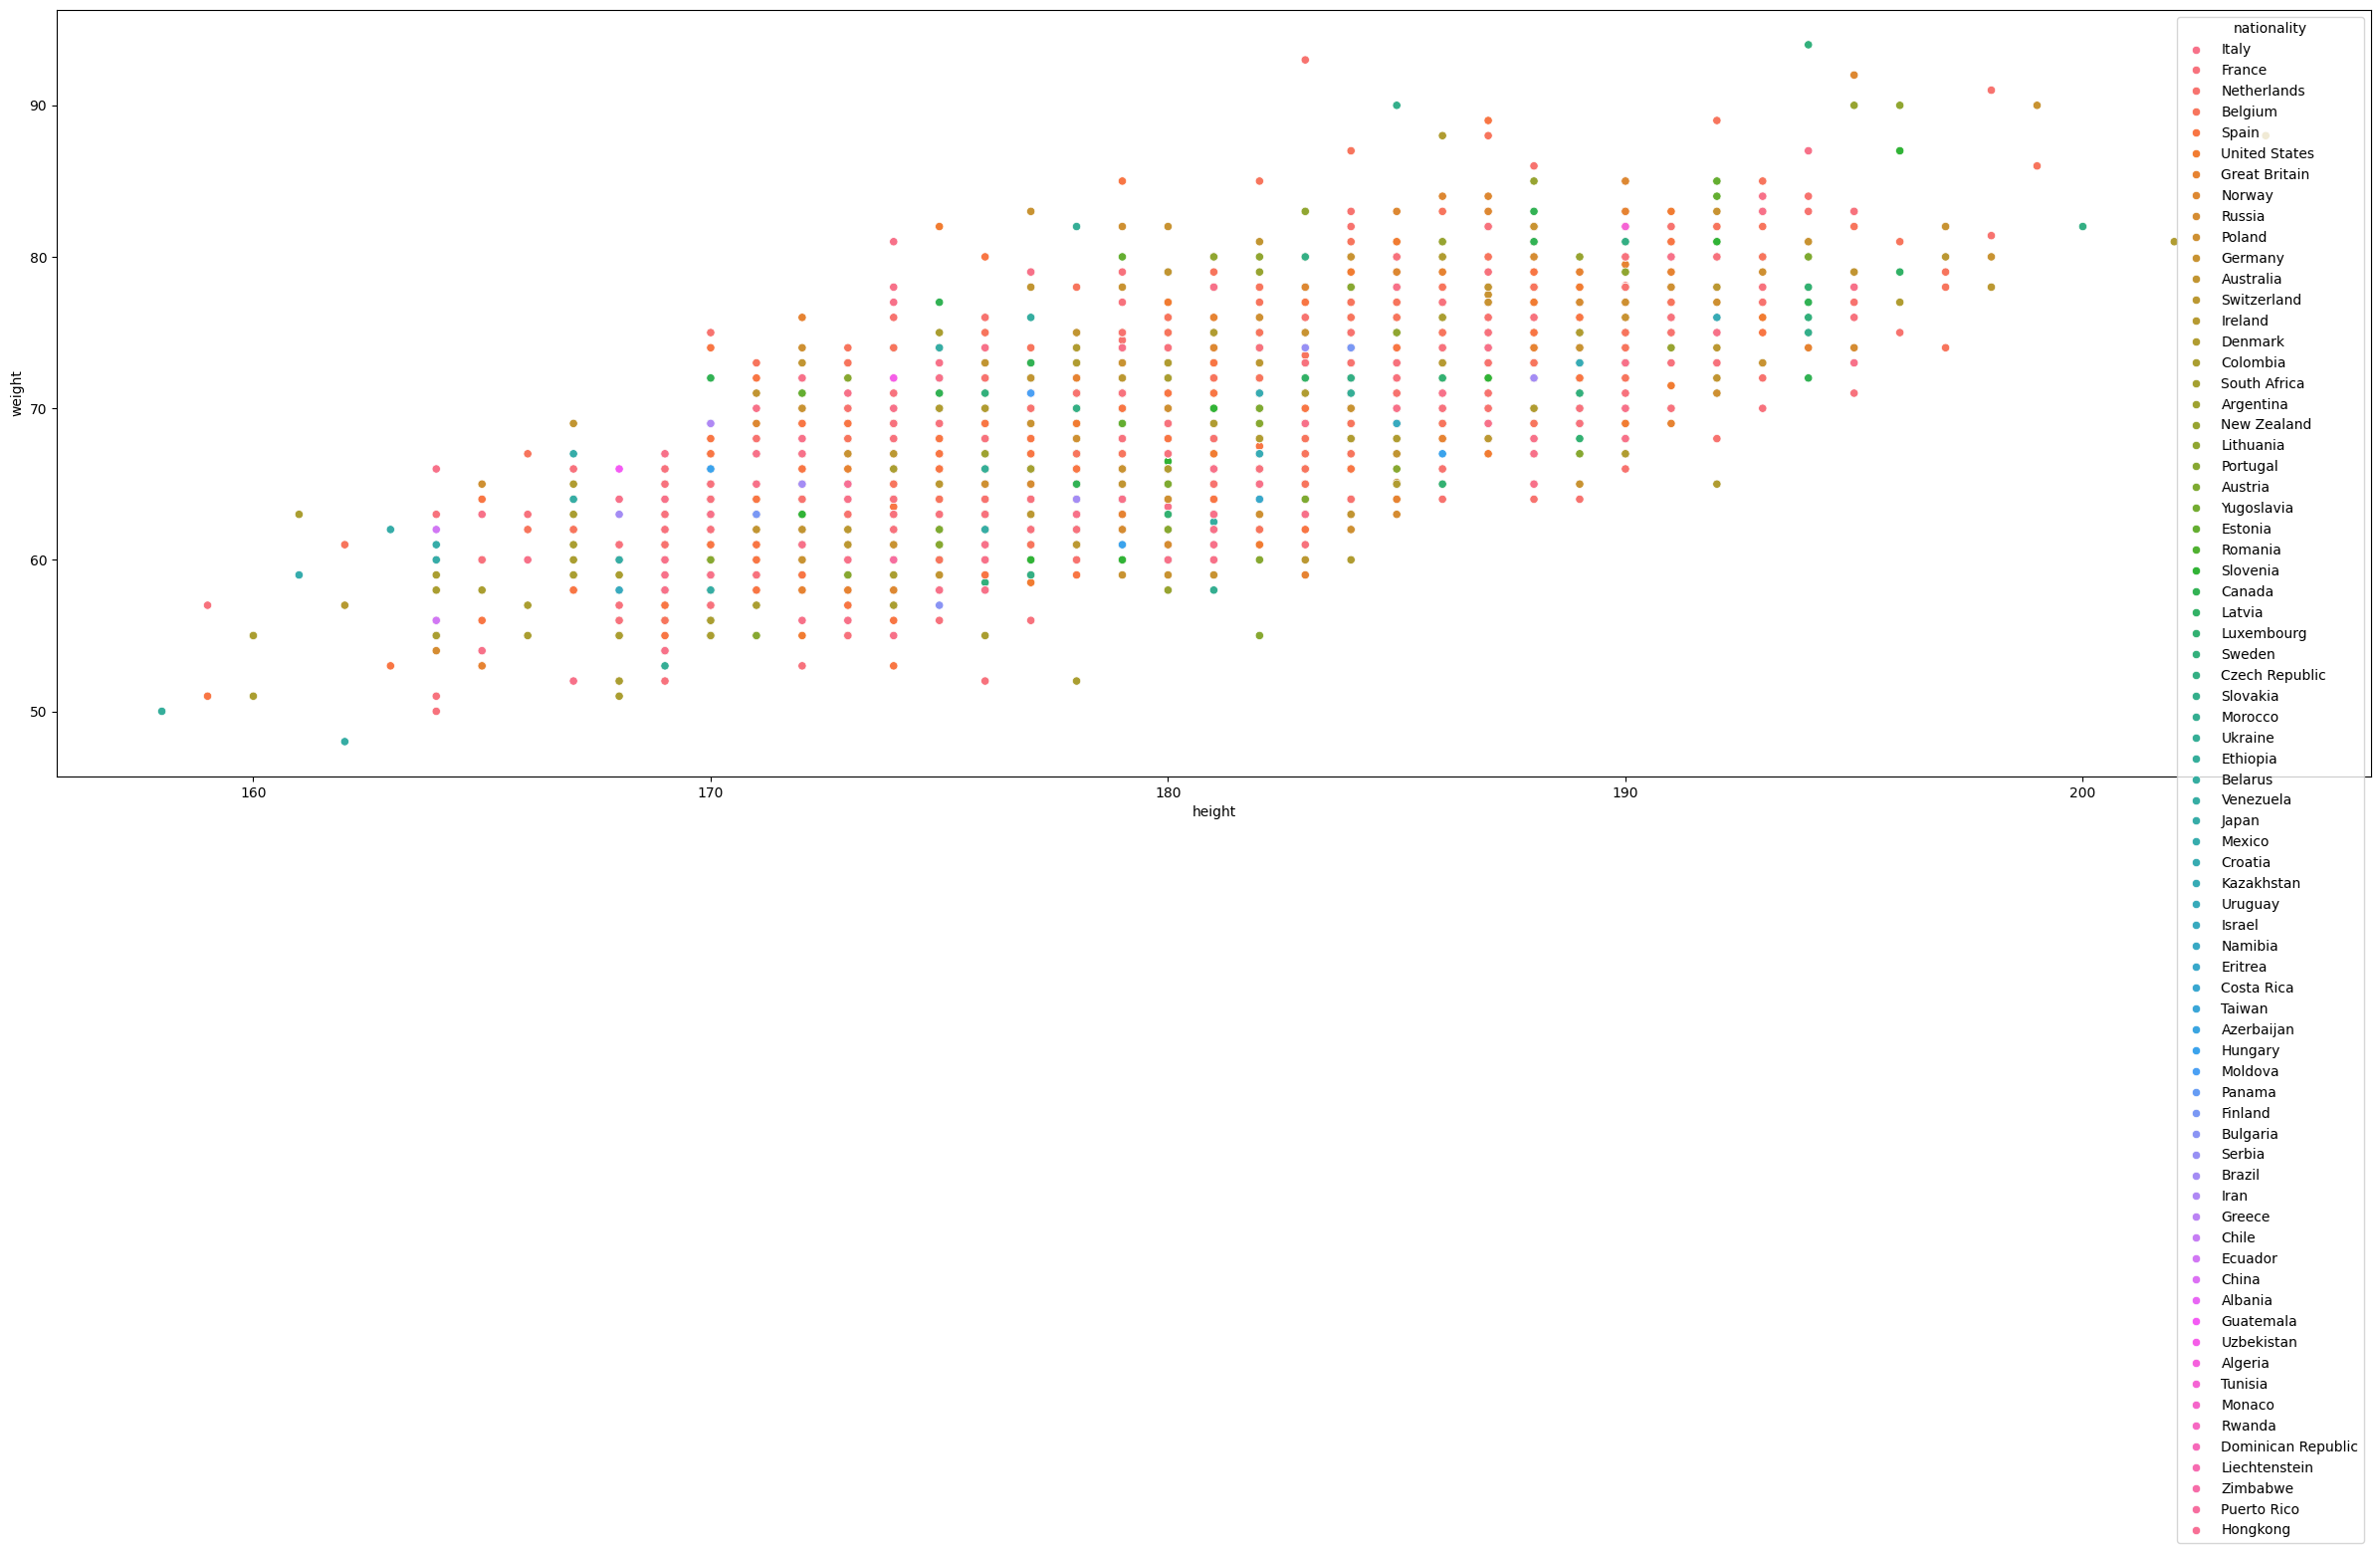

In [30]:
plt.figure(figsize=(30, 10))
sb.scatterplot(x='height', y='weight', data=dataset, hue='nationality')
plt.show()

Dall'analisi qualitativa di questo boxplot emerge che distinguendo per nazionalità le distribuzioni probabilistiche degli attributi altezza e peso non siano particolarmente diversificate. Le poche differenze che possiamo notare (ad esempio Ecuador rispetto a Cina) non sono supportate da una sufficiente quantità di record (confronto tra 5 e 4 ciclisti).

Il tipo di imputazione che abbiamo ipotizzato in precedenza non sarebbe quindi sufficientemente efficace e potrebbe anzi produrre bias "peggiori" rispetto ad altri tipi di imputazione più semplce (come quella statistica). Procederemmo quindi sostituendo le altezze e i pesi mancanti con un'estrazione di valori casuali dalla distribuzione globale degli attributi

In [31]:
normalized_dataset, normalization_scalers_dataset = center_and_scale(dataset)
correlations = correlations(normalized_dataset)
correlations

,birth_year,weight,height,correlation_type
birth_year,1.000000,-0.063740,0.094976,kendall
weight,-0.063740,1.000000,0.539760,kendall
height,0.094976,0.539760,1.000000,kendall
birth_year,1.000000,-0.104242,0.154252,pearson
weight,-0.104242,1.000000,0.720732,pearson
height,0.154252,0.720732,1.000000,pearson
birth_year,1.000000,-0.091220,0.137001,spearman
weight,-0.091220,1.000000,0.705189,spearman
height,0.137001,0.705189,1.000000,spearman


Obiettivo, sostituire i valori mantenendo la distribuzione

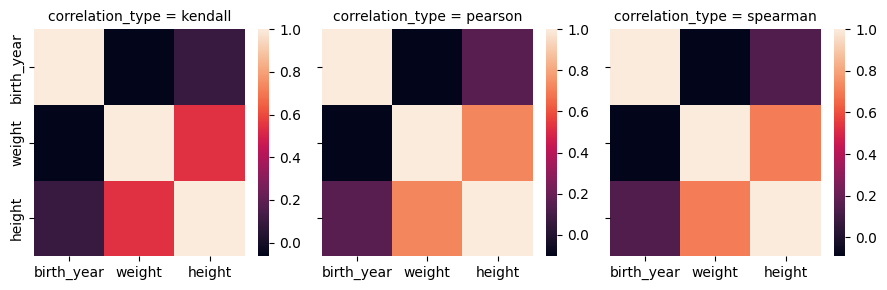

In [32]:
g = sb.FacetGrid(correlations, col="correlation_type")
g.map_dataframe(lambda data, color: sb.heatmap(data[data.columns[:-1]]))

In [33]:
N = len(dataset[dataset['height'].notnull()])
bins = int(1 + 10/3 * math.log10(N))

dataset['height_discretized'] = pd.cut(dataset['height'], bins=bins, labels=[i for i in range(1, bins+1)])

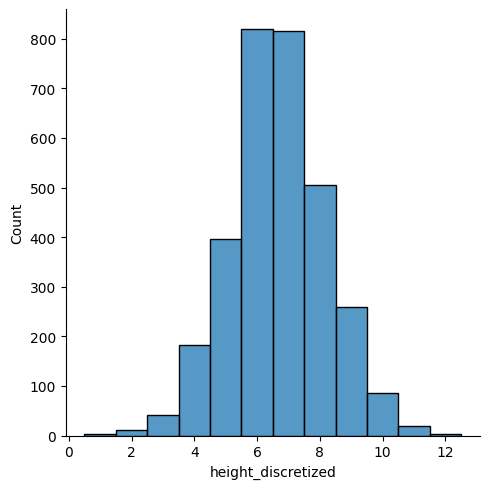

In [34]:
sb.displot(dataset, 
                x="height_discretized", 
                kind="hist",
                row_order="desc",
                bins=len(dataset['height_discretized'].unique()))

In [35]:
dataset['height_discretized'].value_counts(normalize=True).sort_index()
# probabilità di ogni classe di altezza

height_discretized
1     0.001273
2     0.003818
3     0.013045
4     0.058225
5     0.125994
6     0.260579
7     0.259625
8     0.160675
9     0.082405
10    0.027362
11    0.006045
12    0.000955
Name: proportion, dtype: float64

In [36]:
probabilities = dataset['height_discretized'].value_counts(normalize=True).sort_index().to_list()
classes = [i for i in range(1, bins+1)] # the values to be extracted
random_height_discretized = random.choices(classes, weights=probabilities, k=len(dataset[dataset['height_discretized'].isnull()]))
nan_indices = dataset[dataset['height_discretized'].isna()]['height_discretized'].index

for idx, val in zip(nan_indices, random_height_discretized):
    dataset.at[idx, 'height_discretized'] = val

In [37]:
dataset['height_discretized'].isnull().sum()

np.int64(0)

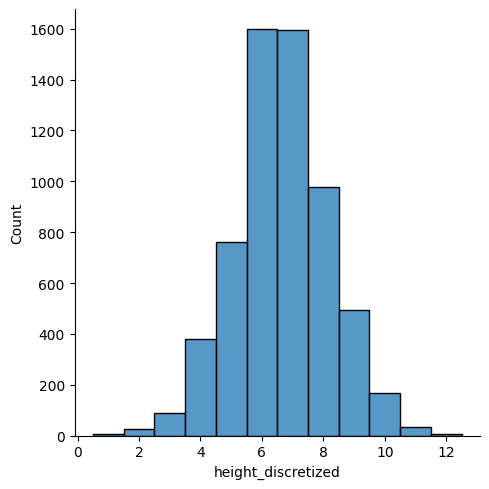

In [38]:
sb.displot(dataset, 
                x="height_discretized", 
                kind="hist",
                row_order="desc",
                bins=len(dataset['height_discretized'].unique()))

Dopo aver sostituito i valori NaN dell'attributo "height_discretized" controlliamo che la distribuzione rimanga pressochè simile a quella originale

In [39]:
mean_heights = dataset[['height', 'height_discretized']].groupby(by='height_discretized', observed=True).mean()['height'] # compute the mean height for each heigt_discretized

def return_mean_height(row):
    return mean_heights[mean_heights.index == row['height_discretized']].iloc[0]

height_to_substitue = dataset[dataset['height'].isnull() & dataset['weight'].isnull()].apply(return_mean_height, axis=1)
dataset.loc[height_to_substitue.index, 'height'] = height_to_substitue.values

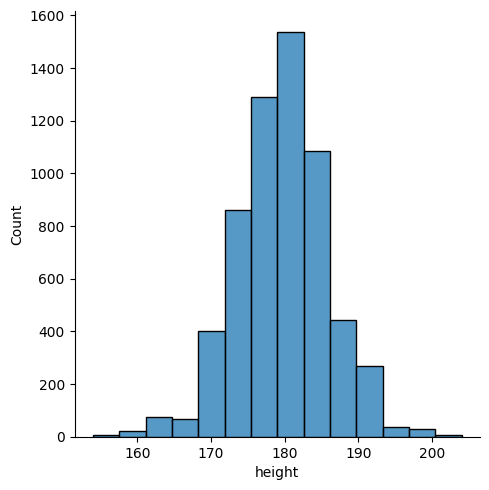

In [40]:
sb.displot(dataset, 
                x="height", 
                kind="hist",
                row_order="desc",
                bins=n_bins)

solito controllo della distribuzione per verificare che sia pressoché simile a quella originale

In [41]:
imputer = KNNImputer(n_neighbors=6) #TODO: controllare bene se vada bene questo valore di n_neighbors

imputed_values = imputer.fit_transform(dataset[['height', 'weight']])
dataset[['height', 'weight']] = imputed_values

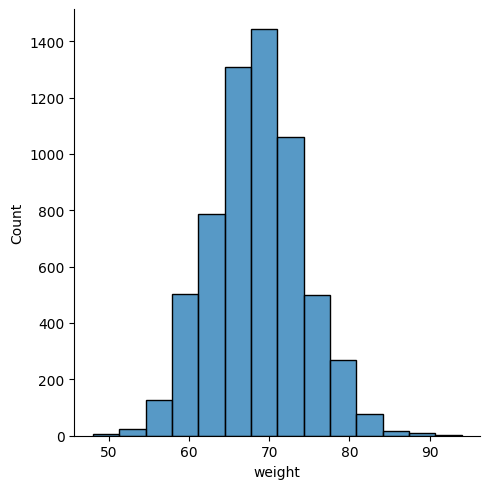

In [42]:
sb.displot(dataset, 
                x="weight", 
                kind="hist",
                row_order="desc",
                bins=n_bins)

per sostituire i valori NaN della feature "weight" abbiamo usato il KNNImputer, utilizzando un numero di vicini che permettesse di mantenere la distribuzione originale